## Бонусное ДЗ №4 Нейросетевое моделирование следующей корзины

#### В этой домашке вам предстоит реализовать нейросеть, которая моделирует паттерны повторных покупок людей

#### Дата выдачи: 11.06.25

#### Жесткий дедлайн: 18.06.25 23:59 MSK

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/latest.js?config=TeX-AMS-MML_HTMLorMML"></script>

In [41]:
import pandas as pd
import numpy as np
import math
from collections import Counter

from matplotlib import pyplot as plt

## Описание задания

В этом задании вам предстоит реализовать нейронную сеть для моделирования поведения пользователей в доменах с высокой частотой повторяющихся взаимодействий между пользователями и товарами (айтемами).

### Структура задания

Задание состоит из трёх основных блоков:

1. **Подготовка данных и базовый подход (макс 3 балла)**
   - Подготовка датасета для экспериментов
   - Реализация простого базового решения (TopPersonal) для последующего сравнения

2. **Реализация нейронной сети BasketHSERec (макс 4 балла)**
   - Реализация архитектуры, моделирующей динамику взаимодействий пользователя с каждым конкретным товаром
   - Учёт временных закономерностей в истории покупок

3. **Эксперименты и анализ (макс 3 балла)**
   - Проведение сравнительных экспериментов между предложенной моделью и базовым подходом
   - Анализ результатов и формулирование выводов

### Особенности задачи

Задание фокусируется на сценариях с:
- Высокой повторяемостью покупок (например, продукты питания, бытовая химия)
- Важностью временных паттернов в поведении пользователей
- Необходимостью персонализированных рекомендаций на основе истории взаимодействий

# Описание модели BasketHSERec


Авторам задания не известна научная статья, в которой бы точно описывалась предлагаемая архитектура, однако она частично вдохновлена упрощёнными идеями из следующих работ:
1. [ReCaNet](https://irlab.science.uva.nl/wp-content/papercite-data/pdf/ariannezhad-2022-recanet.pdf)
2. Недавняя статья [SAFeRec](https://arxiv.org/pdf/2412.14302) от авторов курса. На самом деле, BasketHSERec - это SAFeRec, но без трансформерной части, чтобы не усложнять реализацию

## Постановка задачи

Пусть имеется:
- Множество пользователей $u \in U$
- Множество товаров (айтемов) $i \in I$

Для каждого пользователя составим матрицу $W^u \in \mathbb{R}^{T \times |I|}$, где $w_t^u$ - multihot-вектор корзины покупок в момент времени $t$.

Здесь:
- $t$ представляет дискретные периоды времени от 1 до $T$ (например, дни)
- $w_{t,i}^u = 1$, если пользователь купил товар $i$ в момент $t$, и $0$ в противном случае

**Важно**: матрица будет очень разреженной, поэтому необходимо использовать структуры данных для работы с разреженными матрицами. Но, можно попробовать и на full-connected слоях

Задача: предсказать следующую корзину покупок пользователя в момент времени $T+1$ (например, на следующий день).

**Примечание**: при валидации на разных временных отрезках значение $T$ будет разным для разных пользователей.


## Базовый подход (TopPersonal)


Для пользователя $u$ с историей покупок  $W^u \in \mathbb{R}^{T \times |I|}$:

1. **Суммарный вектор покупок**:
   $$
   s^u = \sum_{t=1}^T w_t^u \quad \in \mathbb{R}^{|I|}
   $$
   где $s_i^u$ — сколько раз пользователь $u$ покупал товар $i$.

2. **Добавление популярности товаров**:
   $$
   p_u^{\text{TopPersonal}} = s^u + pop_{i} \quad \in \mathbb{R}^{|I|}
   $$
   Здесь $\text{pop}_i$ - нормированная популярность товара

3. **Рекомендация**:
   - Сортируем товары по убыванию $ p_u^{\text{TopPersonal}} $
   - Топ-$k$ товаров — предсказанная корзина на $T+1$

## Мотивация для BasketHSERec

Рассмотрим вектор $h_u^i \in \mathbb{R}^T$ - строку в матрице $W^u$, соответствующую товару $i$. Если просто просуммировать его элементы, мы получим общее количество покупок товара, но не учтём временные закономерности.

**Пример**: Допустим, мы наблюдаем 10 дней, и пользователь купил кефир в 1-й, 3-й и 7-й дни. Тогда:

$$h_u^i = [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]$$

Простое суммирование частот не учитывает периодичность покупок. Рассмотрим два случая:
1. $[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]$
2. $[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]$

В первом случае товар был куплен 10 дней назад, во втором - "вчера". Вероятность повторной покупки во втором случае выше, хотя это также зависит от паттернов покупок товара.

## Архитектура BasketHSERec

Определим модель как:

$$y_u^i = \text{BasketHSERec}(h_u^i) = f(h_u^i, i) \in \mathbb{R}$$

где $y_u^i$ предсказывает вероятность покупки товара $i$ пользователем $u$ в момент времени $T+1$.

### Реализация:
1. Функция $f(h_u^i, i)$:
   - Конкатенируем вектор $h_u^i$ и эмбеддинг товара $i$
   - Пропускаем через несколько полносвязных (FC) слоёв с нелинейной активацией
   - На выходе получаем одно число (вероятность покупки)

2. Функция потерь:
   - Используем бинарную кросс-энтропию для классификации (покупка/нет покупки)
   - **Важно**: рассматриваем только товары, которые пользователь уже покупал ранее


## Описание данных

Для выполнения задания используется датасет **Dunnhumby - The Complete Journey**, содержащий историю покупок пользователей.

**Исходные данные**:  
[Официальная версия на Kaggle](https://www.kaggle.com/datasets/frtgnn/dunnhumby-the-complete-journey)  

**Подготовленная версия**:  
[Яндекс.Диск](https://disk.yandex.ru/d/PPpfc9a4I9Y38w) (удалены лишние колонки для удобства работы)

## Система оценивания

### 1. Подготовка данных (1 балл)
- [ ] Подготовлены обучающий и тестовый датасеты
- [ ] Использована схема разбиения:
  - Leave-one-basket (последняя корзина как тест) **или**
  - Time-based split (последний день как тест)
- [ ] *(Опционально)* Реализована валидационная выборка и перебор параметров

### 2. Реализация TopPersonal (2 балла)
- [ ] Корректно реализован алгоритм TopPersonal
- [ ] Рассчитаны метрики качества:
  - NDCG@3 и Recall@3
  - NDCG@10 и Recall@10
- [ ] Результаты представлены в понятном формате

### 3. Обучение BasketHSERec (2 балла)
- [ ] Реализован код обучения модели
- [ ] Продемонстрирован процесс обучения:
  - Графики обучения/потерь
  - Логи процесса (например, через tqdm)
- [ ] Сохранены веса обученной модели

### 4. Сравнение с TopPersonal (3 балла)
- [ ] Проведено сравнение BasketHSERec и TopPersonal
- [ ] Показано преимущество BasketHSERec по метрикам:
  - NDCG@3/10
  - Recall@3/10
- [ ] Результаты представлены в табличном виде с четкими выводами

### 5. Анализ архитектурных решений (2 балла)
- [ ] Проведено сравнение вариантов BasketHSERec:
  
  | Вариант               | NDCG@3 | Recall@3 | NDCG@10 | Recall@10 |
  |-----------------------|--------|----------|---------|-----------|
  | a) History + Embeddings |        |          |         |           |
  | b) Только Embeddings    |        |          |         |           |
  | c) Только History       |        |          |         |           |
  | TopPersonal (baseline)  |        |          |         |           |

- [ ] Сделаны содержательные выводы о влиянии компонентов модели

In [2]:
df = pd.read_parquet('dunnhumby_norm.pq')
df.head()

,user_id,day,item_id
0,2375,1,1004906
1,2375,1,1033142
2,2375,1,1036325
3,2375,1,1082185
4,2375,1,8160430


### 1. Подготовка данных (1 балл)


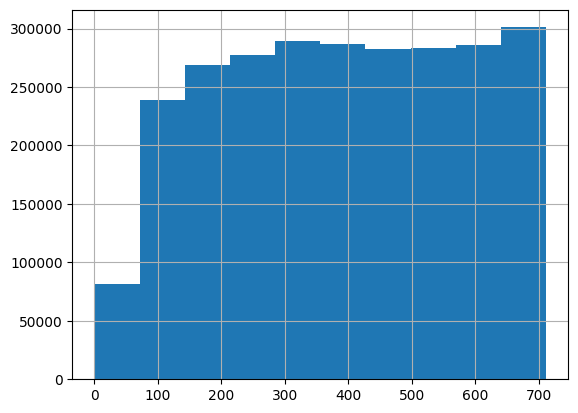

In [14]:
df.day.hist()
plt.show()

Для разбиения на train и test реализуем time-basket split подход:

In [3]:
df.day.min(), df.day.max()

(1, 711)

In [4]:
711 * 0.8

568.8000000000001

In [6]:
train_df = df.loc[(df.day < 568)].copy()
test_df = df.loc[(df.day >= 568)].copy()

In [10]:
train_df.shape[0], test_df.shape[0]

(2005647, 590085)

Сгруппируем айтемы по пользователям и в дальнешем наши прогнозы будем добавлять в качестве отдельной колонки predict (так удобнее реализовать функции расчета метрик):

In [18]:
train_grouped = train_df.groupby('user_id')['item_id'].apply(list).reset_index(name='ground_true')
train_grouped.head()

,user_id,ground_true
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."
2,3,"[866211, 878996, 882830, 904360, 921345, 93194..."
3,4,"[836163, 857849, 877523, 878909, 883932, 89142..."
4,5,"[938983, 5980822, 1012352, 825538, 1002499, 69..."


In [19]:
test_grouped = test_df.groupby('user_id')['item_id'].apply(list).reset_index(name='ground_true')
train_grouped.head()

,user_id,ground_true
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."
2,3,"[866211, 878996, 882830, 904360, 921345, 93194..."
3,4,"[836163, 857849, 877523, 878909, 883932, 89142..."
4,5,"[938983, 5980822, 1012352, 825538, 1002499, 69..."


### 2. Реализация TopPersonal (2 балла)


Реализуем функции для расчета NDCG@k и Recall@k:

In [20]:
def ndcg_at_k(recommended, actual, k):
    recommended_k = recommended[:k]
    actual_set = set(actual)
    dcg = 0.0
    for i, item in enumerate(recommended_k):
        if item in actual_set:
            dcg += 1 / math.log2(i + 2)
    ideal_hits = min(len(actual_set), k)
    idcg = sum(1 / math.log2(i + 2) for i in range(ideal_hits))
    return dcg / idcg if idcg > 0 else 0.0

def mean_ndcg_at_k(df, k):
    ndcgs = []
    for _, row in df.iterrows():
        actual = row['ground_true']
        predicted = row['predict']
        ndcgs.append(ndcg_at_k(predicted, actual, k))
    return sum(ndcgs) / len(ndcgs) if ndcgs else 0.0

In [21]:
def recall_at_k(recommended, actual, k):
    recommended_k = recommended[:k]
    actual_set = set(actual)
    hits = len(set(recommended_k) & actual_set)
    return hits / len(actual_set) if actual_set else 0.0

def mean_recall_at_k(df, k):
    recalls = []
    for _, row in df.iterrows():
        actual = row['ground_true']
        predicted = row['predict']
        recalls.append(recall_at_k(predicted, actual, k))
    return sum(recalls) / len(recalls) if recalls else 0.0

Реализуем алгоритм TopPersonal

In [35]:
class TopPersonalRecommender:
    def __init__(self):
        self.user_hist = None
        self.top_popular = None

    def fit(self, train_df, user_col='user_id', items_col='ground_true'):
        self.user_hist = train_df.set_index(user_col)[items_col].to_dict()

        all_items = [item for sublist in train_df[items_col] for item in sublist]
        popular_counter = Counter(all_items)
        self.top_popular = [item for item, _ in popular_counter.most_common(100)]

    def recommend(self, test_df, k=10, user_col='user_id'):
        predicts = []

        for user in test_df[user_col]:
            user_items = self.user_hist.get(user, [])

            freq = Counter(user_items)
            sorted_items = [item for item, _ in freq.most_common()]

            to_add = [item for item in self.top_popular if item not in sorted_items]
            sorted_items.extend(to_add)

            predict = sorted_items[:k]
            predicts.append(predict)

        result_df = test_df.copy()
        result_df['predict'] = predicts
        return result_df

Обучим модель и сделаем рекомендации:

In [38]:
model = TopPersonalRecommender()
model.fit(train_grouped)

In [39]:
recs = model.recommend(test_grouped)
recs.head()

,user_id,ground_true,predict
0,1,"[840361, 856942, 857006, 859676, 868006, 87737...","[856942, 1082185, 995242, 9527290, 940947, 104..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504...","[8090521, 1106523, 5569230, 1075368, 1133018, ..."
2,3,"[946839, 953476, 1053690, 835476, 851057, 8720...","[1092026, 1053690, 951590, 998206, 1106523, 91..."
3,4,"[947095, 951821, 962229, 990797, 6773204, 1311...","[883932, 6391541, 891423, 910109, 943030, 9364..."
4,5,"[833238, 962199, 1026699, 962199, 1003031, 105...","[6904776, 6773079, 1126899, 5995628, 925054, 9..."


Оценим качество модели:

In [42]:
mean_ndcg_at_k(recs, 3), mean_ndcg_at_k(recs, 10)

(0.6532682922855212, 0.5619893648859201)

In [43]:
mean_recall_at_k(recs, 3), mean_recall_at_k(recs, 10)

(0.021837509594971986, 0.04862104152203856)

### 3. Обучение BasketHSERec (2 балла)

### 4. Сравнение с TopPersonal (3 балла)


### 5. Анализ архитектурных решений (2 балла)